## 目的

arcfaceの埋め込み次元を比較する。

- 512
- 1024
- 1792

In [1]:
import sys
import gc
from pathlib import Path

import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2
import torch
import torch.nn as nn
import timm
import faiss
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import japanize_matplotlib
from cosine_annealing_warmup import CosineAnnealingWarmupRestarts
from torch.optim import AdamW
from transformers import (
    get_cosine_schedule_with_warmup,
    get_linear_schedule_with_warmup,
)
from sklearn.model_selection import StratifiedKFold, ParameterGrid
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm
from torch.utils.data import DataLoader
from pytorch_metric_learning import losses, samplers


from src.const import (
    TRAIN_CSV_WITH_IMG_PATH,
    QUERY_IMAGES_PATH,
    CITE_IMAGES_PATH,
    OUTPUT_ROOT,
    DATA_ROOT
)
from src.utils import (
    Logger,
    mrr_at_k_by_searched_index,
    seed_torch
)
from src.data_handler import (
    add_fold_idx,
    load_trainable_df,
    make_label_dict
)
from src.datasets import (
    TrainDataset,
    TestDataset
)
from src.searcher import SimilaritySearcher
from src.layer.gem import GeM
from src.layer.arcface import ArcMarginProduct
from src.loss.focal_loss import FocalLoss

In [2]:
class Config:
    name = 'tuning'
    out_dir = OUTPUT_ROOT / name / 'arcface_embedding_dim'
    out_dir.mkdir(parents=True, exist_ok=True)
    debug = False

    seed = 8823
    n_fold = 5
    trn_fold = [0, 1, 2, 3, 4]

    target_columns = ['meigara_label']
    img_size = 128

    model_name = 'tf_efficientnet_b0.ns_jft_in1k'
    max_epochs = 5
    train_batch_size = 16 * 4
    valid_batch_size = 256
    num_workers = 4
    gradient_accumulation_steps = 1
    clip_grad_norm = 1000

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    optimizer = dict(
        optimizer_name="AdamW",
        lr=1e-4 * 4,
        weight_decay=1e-2,
        eps=1e-6,
        beta=(0.9, 0.999),
        encoder_lr=1e-4,
        decoder_lr=1e-4,
    )

    scheduler = dict(
        scheduler_name="cosine",
        num_warmup_steps_rate=0,
        num_cycles=0.5,
    )
    batch_scheduler = True

if Config.debug:
    Config.n_fold = 2
    Config.max_epochs = 2

In [3]:
def extract_features(model, data_loader, device):
    preds, targets = [], []
    model.eval()
    model.to(device)
    tbar = tqdm(data_loader, total=len(data_loader))
    for batch in tbar:
        for k, v in batch.items():
            batch[k] = v.to(device)
        with torch.no_grad():
            outputs = model.extract_features(batch['images'])
        outputs = outputs.cpu().detach().numpy()
        target_labels = batch['targets'].cpu().detach().numpy()
        preds.append(outputs)
        targets.append(target_labels)
    return np.concatenate(preds), np.concatenate(targets)


def get_transforms(*, size, data="train"):

    if data == 'train':
        return A.Compose([
            # 正方形切り出し
            A.RandomResizedCrop(size, size, scale=(0.85, 1.0)),
            A.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225],
            ),
            ToTensorV2(),
        ])

    elif data == 'valid':
        return A.Compose([
            A.Resize(size, size),
            A.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225],
            ),
            ToTensorV2(),
        ])

In [4]:
def get_index_and_query_df(base_df, target_col=Config.target_columns[0], unique_id_col='gid', seed=Config.seed):
    """index, queryに対応するデータフレームを返す
    Args:
        base_df: 分岐元データフレーム
        target_col: 目的変数絡む
        unique_id_col: ユニークなカラム名
        seed: queryを選択する際のシード値
    Returns:
        (indexデータフレーム, queryデータフレーム)
    """
    # カウント数が1より多いものをクエリー画像候補とする。
    counts_df = base_df[target_col].value_counts()
    counts_df = counts_df[counts_df != 1]
    query_candidates = base_df[base_df[target_col].isin(counts_df.index)]
    # 目的変数から各カテゴリ1つずつランダムに取得してクエリ画像とする。
    query_target_target_id_list = query_candidates.groupby(target_col).sample(
        1,
        random_state=seed)[unique_id_col].to_list()
    is_query_filter = base_df[unique_id_col].isin(query_target_target_id_list)
    return base_df[~is_query_filter], base_df[is_query_filter]

In [5]:
# データの準備
(train_df, _, _, _) = load_trainable_df(
    train_csv_path=DATA_ROOT / 'train.csv',
    test_csv_path=DATA_ROOT / 'test.csv',
    cite_csv_path=DATA_ROOT / 'cite.csv',
    sample_submission_csv_path=DATA_ROOT / 'sample_submission.csv',
    seed=Config.seed,
    debug=Config.debug
)
MLABEL2MEIGARA, BLABEL2BLAND = make_label_dict(train_df)
train_df = add_fold_idx(
    train_df,
    Config.n_fold,
    seed=Config.seed,
    target_columns=Config.target_columns
)
Config.num_classes = len(train_df[Config.target_columns[0]].unique())
train_df.head()

/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


,gid,filename,brand_id,meigara,brand_id_label,meigara_label,filepath,fold
0,200000001,200000001.jpg,3372,五橋,2211,445,/work/data/query_images/200000001.jpg,3
1,200000002,200000002.jpg,3751,庭のうぐいす,2454,1122,/work/data/query_images/200000002.jpg,4
2,200000003,200000003.jpg,2856,笑四季,1864,1819,/work/data/query_images/200000003.jpg,3
3,200000004,200000004.jpg,1527,鍋島,1005,2263,/work/data/query_images/200000004.jpg,1
4,200000005,200000005.jpg,2676,仙禽,1739,478,/work/data/query_images/200000005.jpg,2


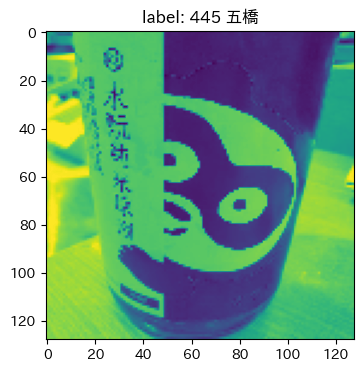

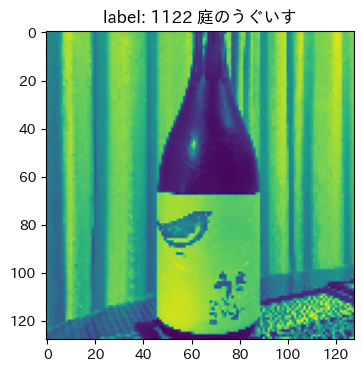

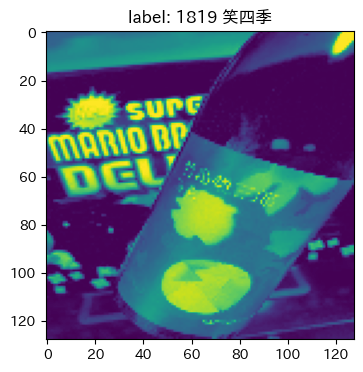

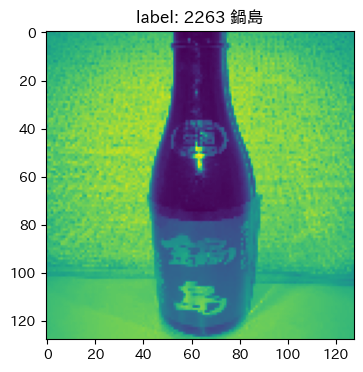

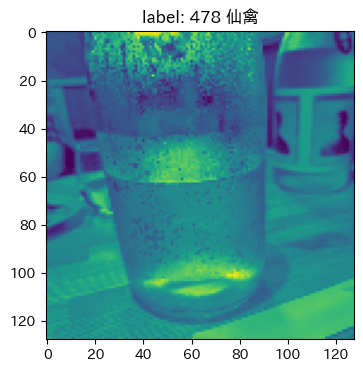

In [6]:
train_dataset = TrainDataset(
    df=train_df,
    transform_fn=get_transforms(data="train", size=Config.img_size),
    target_columns=Config.target_columns
)
japanize_matplotlib.japanize()
for i in range(5):
    plt.figure(figsize=(4, 4))
    batch = train_dataset[i]
    image, label = batch["images"],  batch["targets"]
    plt.imshow(image[0])
    plt.title(f"label: {int(label)} {MLABEL2MEIGARA[int(label)]}")
    plt.show()

## Model

In [6]:
class CustomModel(nn.Module):
    def __init__(self, config, embedding_dim=512, pretrained=False, ls_eps=0.0):
        super().__init__()
        self.config = config
        self.model = timm.create_model(self.config.model_name, pretrained=pretrained)
        self.n_features = self.model.classifier.in_features
        self.model.global_pool = GeM()
        self.model.classifier = nn.Identity()  # custom head にするため
        self.fc = nn.Linear(self.n_features, embedding_dim)
        self.bn = nn.BatchNorm1d(embedding_dim)
        self.final = ArcMarginProduct(
            embedding_dim,
            config.num_classes,
            ls_eps=ls_eps
        )

    def _init_params(self):
        nn.init.xavier_normal_(self.fc.weight)
        nn.init.constant_(self.fc.bias, 0)
        nn.init.constant_(self.bn.weight, 0)
        nn.init.constant_(self.bn.bias, 0)

    def forward(self, x, label):
        x = self.extract_features(x)
        x = self.final(x, label)
        return x

    def extract_features(self, images, labels=None):
        bs = images.size(0)
        x = self.model(images).view(bs, -1)
        x = self.fc(x)
        x = self.bn(x)
        return x

In [8]:
model = CustomModel(Config).cuda()
x = torch.rand(2, 3, 224, 224).cuda()
label = torch.tensor([1, 1]).cuda()
model(x, label).size()

torch.Size([2, 2499])

In [7]:
LOGGER = Logger(str(Config.out_dir))

In [8]:
def get_optimizer(optimizer_config, params):
    if optimizer_config["optimizer_name"] == "AdamW":
        optimizer = AdamW(
            params,
            lr=optimizer_config["lr"],
            betas=optimizer_config["beta"],
            eps=optimizer_config["eps"],
        )
        return optimizer
    else:
        raise NotImplementedError


def get_scheduler(scheduler_config, optimizer, num_train_steps):
    if scheduler_config["scheduler_name"] == "linear":
        scheduler = get_linear_schedule_with_warmup(
            optimizer,
            num_warmup_steps=int(scheduler_config["num_warmup_steps_rate"] * num_train_steps),
            num_training_steps=num_train_steps,
        )
        return scheduler

    elif scheduler_config["scheduler_name"] == "cosine":
        scheduler = get_cosine_schedule_with_warmup(
            optimizer,
            num_warmup_steps=int(scheduler_config["num_warmup_steps_rate"] * num_train_steps),
            num_training_steps=num_train_steps,
            num_cycles=scheduler_config["num_cycles"],
        )
        return scheduler

    elif scheduler_config["scheduler_name"] == "cosine_restarts":
        """
        example:
            first_cycle_steps_ratio = 0.25,
            cycle_mult = 1.0,
            max_lr = 2e-5,
            min_lr = 1e-7,
            warmup_steps=100,
            gamma=0.8)
        """
        scheduler = CosineAnnealingWarmupRestarts(
            optimizer,
            first_cycle_steps=int(num_train_steps * scheduler_config["first_cycle_steps_ratio"]),
            cycle_mult=scheduler_config["cycle_mult"],
            max_lr=scheduler_config["max_lr"],
            min_lr=scheduler_config["min_lr"],
            warmup_steps=scheduler_config["warmup_steps"],
            gamma=scheduler_config["gamma"],
        )
        return scheduler

    else:
        raise NotImplementedError

In [9]:
def train_fn(
    config,
    model,
    dataloader,
    criterion,
    optimizer,
    scheduler,
    device,
    _custom_step,
):
    model.train()
    scaler = torch.cuda.amp.GradScaler()
    losses = []

    tbar = tqdm(enumerate(dataloader), total=len(dataloader))
    for step, batch in tbar:
        for k, v in batch.items():
            batch[k] = v.to(device)
        targets = batch["targets"]
        batch_size = targets.size(0)

        with torch.cuda.amp.autocast():
            batch_outputs = model(batch["images"], label=batch["targets"])
            loss = criterion(batch_outputs, targets)

        if config.gradient_accumulation_steps > 1:
            loss = loss / config.gradient_accumulation_steps

        scaler.scale(loss).backward()
        if config.clip_grad_norm is not None:
            torch.nn.utils.clip_grad_norm_(model.parameters(), config.clip_grad_norm)
            torch.nn.utils.clip_grad_norm_(criterion.parameters(), config.clip_grad_norm)

        if (step + 1) % config.gradient_accumulation_steps == 0:
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()
            _custom_step += 1

            if config.batch_scheduler:
                scheduler.step()

        losses.append(float(loss))
        tbar.set_description(f"loss: {np.mean(losses):.4f} lr: {scheduler.get_lr()[0]:.6f}")

    loss = np.mean(losses)
    return loss, _custom_step


def train_loop(
    model,
    train_dataloader,
    index_dataloader,
    query_dataloader,
    config,
    criterion,
    best_model_dst,
):
    LOGGER.info(f"========== training ==========")

    # set model & optimizer
    params = [
        {'params': model.parameters()},
    ]
    optimizer = get_optimizer(optimizer_config=config.optimizer, params=params)

    # set scheduler
    num_train_steps = int(
        len(train_dataloader) * config.max_epochs // config.gradient_accumulation_steps
    )
    scheduler = get_scheduler(
        scheduler_config=config.scheduler, optimizer=optimizer, num_train_steps=num_train_steps
    )

    # loop
    best_mrr = -np.inf
    tr_step, val_step = 0, 0
    for epoch in range(Config.max_epochs):
        # training
        loss, tr_step = train_fn(
            config=config,
            model=model,
            dataloader=train_dataloader,
            criterion=criterion,
            optimizer=optimizer,
            scheduler=scheduler,
            device=config.device,
            _custom_step=tr_step,
        )
        # validation
        index_preds, index_targets = extract_features(model, index_dataloader, config.device)
        query_preds, query_targets = extract_features(model, query_dataloader, config.device)
        searcher = SimilaritySearcher(index_preds)
        _, I = searcher.search(query_preds)
        mrr = mrr_at_k_by_searched_index(query_targets, index_targets, I)

        logs = {
            "Epoch": epoch,
            "train_loss_epoch": loss.item(),
            "valid_mrr": mrr,
        }
        LOGGER.info(logs)

        if mrr > best_mrr:
            best_mrr = mrr
            LOGGER.info(f"epoch {epoch} - best mrr: {best_mrr:.4f} model")

            torch.save(
                model.state_dict(),
                best_model_dst
            )

        if not config.batch_scheduler:
            scheduler.step()

    torch.cuda.empty_cache()
    gc.collect()
    model.load_state_dict(torch.load(best_model_dst))
    index_preds, index_targets = extract_features(model, index_dataloader, config.device)
    query_preds, query_targets = extract_features(model, query_dataloader, config.device)
    searcher = SimilaritySearcher(index_preds)
    _, I = searcher.search(query_preds)
    mrr = mrr_at_k_by_searched_index(query_targets, index_targets, I)
    return mrr

In [10]:
def get_dl(train_df, index_df, query_df, config=Config):
    train_dataset = TrainDataset(
        df=train_df,
        target_columns=config.target_columns,
        transform_fn=get_transforms(data="train", size=config.img_size)
    )
    index_dataset = TrainDataset(
        df=index_df,
        target_columns=config.target_columns,
        transform_fn=get_transforms(data="valid", size=config.img_size)
    )
    query_dataset = TrainDataset(
        df=query_df,
        target_columns=config.target_columns,
        transform_fn=get_transforms(data="valid", size=config.img_size)
    )
    train_dataloader = DataLoader(
        train_dataset,
        batch_size=config.train_batch_size,
        shuffle=True,
        num_workers=config.num_workers,
        pin_memory=True,
        drop_last=True,
    )
    index_dataloader = DataLoader(
        index_dataset,
        batch_size=config.valid_batch_size,
        num_workers=config.num_workers,
        pin_memory=True,
        drop_last=False,
    )
    query_dataloader = DataLoader(
        query_dataset,
        batch_size=config.valid_batch_size,
        num_workers=config.num_workers,
        pin_memory=True,
        drop_last=False,
    )
    return train_dataloader, index_dataloader, query_dataloader

In [11]:
seed_torch()

params = [
    {
        'embedding_dim': 1792,
    },
    {
        'embedding_dim': 1024,
    },
    {
        'embedding_dim': 512,
    },
]
log_df = []
for param in params:
    LOGGER.info(param)
    mrr_list = []
    for i_fold in range(Config.n_fold):
        LOGGER.info(f'=======fold:{i_fold}=======')
        if i_fold not in Config.trn_fold:
            continue
        train_df_fold = train_df[train_df['fold'] != i_fold]
        valid_df_fold = train_df[train_df['fold'] == i_fold]
        index_df, query_df = get_index_and_query_df(valid_df_fold)
        train_dataloader, index_dataloader, query_dataloader = get_dl(
            train_df_fold,
            index_df,
            query_df,
        )
        model = CustomModel(Config, pretrained=True, ls_eps=0.1, embedding_dim=param['embedding_dim'])
        model.to(Config.device)
        criterion = FocalLoss()
        arr = train_loop(
            model=model,
            train_dataloader=train_dataloader,
            index_dataloader=index_dataloader,
            query_dataloader=query_dataloader,
            config=Config,
            criterion=criterion,
            best_model_dst=Config.out_dir / 'best_model.pth',
        )
        mrr_list.append(arr)
    mrr_mean = np.mean(mrr_list)
    LOGGER.info(mrr_mean)
    log_df.append({
        'mrr': mrr_mean,
        'embedding_dim': param['embedding_dim']
    })
log_df = pd.DataFrame(log_df)

[2023-08-27 04:47:04] - {'embedding_dim': 1792}
[2023-08-27 04:47:04] - =======fold:0=======
[2023-08-27 04:47:05] - ========== training ==========
  0% 0/1352 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:265: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "
loss: 12.7475 lr: 0.000362: 100% 1352/1352 [02:33<00:00,  8.80it/s]
100% 80/80 [00:34<00:00,  2.31it/s]
100% 5/5 [00:02<00:00,  1.69it/s]
[mrr]: 100% 1205/1205 [00:00<00:00, 384052.91it/s]
[2023-08-27 04:50:17] - {'Epoch': 0, 'train_loss_epoch': 12.747476489586237, 'valid_mrr': 0.4125696522630735}
[2023-08-27 04:50:17] - epoch 0 - best mrr: 0.4126 model
loss: 7.7656 lr: 0.000262: 100% 1352/1352 [02:30<00:00,  8.99it/s]
100% 80/80 [00:33<00:00,  2.39it/s]
100% 5/5 [00:02<00:00,  1.76it/s]
[mrr]: 100% 1205/1205 [00:00<00:00, 470502.36it/s]
[2023-08-27 04:53:24] - {'Epoch':

In [12]:
display(log_df.sort_values(by='mrr', ascending=False))
log_df.to_csv(Config.out_dir / 'mrr_logs.csv', index=False)

,mrr,embedding_dim
1,0.512715,1024
0,0.511872,1792
2,0.510614,512
